In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

% matplotlib inline

## Question 2

### Download dataset

In [ ]:
import os
import urllib.request
import zipfile

data_dir = '/data/flights'
    
data_dir = os.path.join(data_dir)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

yr = [2014, 2015, 2016]
mm = np.arange(1,13)

for y in yr:
    for m in mm:
        DATA_URL = 'https://transtats.bts.gov/PREZIP/On_Time_On_Time_Performance_{}_{}.zip'.format(y, m)

        filename = DATA_URL.split('/')[-1]
        filepath = os.path.join(data_dir, filename)

        if not os.path.exists(filepath):
            filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath)
            zip_ref = zipfile.ZipFile(filepath, 'r')
            zip_ref.extractall(data_dir)
            zip_ref.close()
            os.remove(data_dir + '/' + filename)
            print('Successfullly downloaded', filename)

### Change data-format to reduce memory usage

First, we will take an example table and inspect the memory usage for each data type: float, int and object

In [2]:
filename = '/data/flights/On_Time_On_Time_Performance_2014_1.csv'
data_fl = pd.read_csv(filename)

In [4]:
data_fl.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum',
       ...
       'Div4TailNum', 'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID',
       'Div5WheelsOn', 'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff',
       'Div5TailNum', 'Unnamed: 109'],
      dtype='object', length=110)

In [3]:
list(data_fl.iloc[0])

[2014,
 1,
 1,
 1,
 3,
 '2014-01-01',
 'AA',
 19805,
 'AA',
 'N338AA',
 1,
 12478,
 1247802,
 31703,
 'JFK',
 'New York, NY',
 'NY',
 36,
 'New York',
 22,
 12892,
 1289203,
 32575,
 'LAX',
 'Los Angeles, CA',
 'CA',
 6,
 'California',
 91,
 900,
 914.0,
 14.0,
 14.0,
 0.0,
 0.0,
 '0900-0959',
 20.0,
 934.0,
 1233.0,
 5.0,
 1225,
 1238.0,
 13.0,
 13.0,
 0.0,
 0.0,
 '1200-1259',
 0.0,
 nan,
 0.0,
 385.0,
 384.0,
 359.0,
 1.0,
 2475.0,
 10,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
for dtype in ['float64','int64','object']:
    data_dtype = data_fl.select_dtypes(include=[dtype])
    tt_usage_b = data_dtype.memory_usage(deep=True).sum()
    tt_usage_mb = tt_usage_b / 1024 ** 2
    print("Total memory usage for {} columns: {:.3f} MB".format(dtype, tt_usage_mb))

In [13]:
def memory_usage(df):
    tt_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    print("Total memory usage {:.3f} MB".format(tt_usage))

Before merging all the table, we will apply down-casting without losing informaiton on int, float data type. We will also change the NAN data type as well as use category datatypte to store object variable.

In [3]:
def down_cast(df, filename):
    
    print('Downcasting...' + filename.split('/')[-1])
    df_int = df.select_dtypes(include=['int'])
    df_float = df.select_dtypes(include=['float'])
    df_obj = df.select_dtypes(include=['object'])
    
    df_int_cv = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_float_cv = df_float.apply(pd.to_numeric, downcast='float')
    null_columns= df_float_cv.columns[df_float_cv.isnull().all()]
    df_float_cv[null_columns] = df_float_cv[null_columns].astype('float16')
    
    df_obj_cv = pd.DataFrame()
    for col in df_obj.columns:
        num_unique_values = len(df_obj[col].unique())
        num_total_values = len(df_obj[col])
        if num_unique_values / num_total_values < 0.5:
            df_obj_cv.loc[:,col] = df_obj[col].astype('category')
        else:
            df_obj_cv.loc[:,col] = df_obj[col]
            
    pd_new = pd.concat([df_int_cv, df_obj_cv, df_float_cv], axis=1)
    
    return pd_new

In [62]:
memory_usage(data_fl)
data_fl_cv = down_cast(data_fl)
memory_usage(data_fl_cv)

Total memory usage 800.439 MB
Downcasting...
Total memory usage 199.354 MB


### Process each .csv file and combine them

In [4]:
data_fl = pd.DataFrame(data=None)

yr = [2014]
mm = np.arange(1,4)
for y in yr:
    for m in mm:
        filename = '/data/flights/On_Time_On_Time_Performance_{}_{}.csv'.format(y, m)
        print('Processing ' + filename + '...')

        data_tmp = pd.read_csv(filename)
        data_tmp_cv = down_cast(data_tmp, filename)
        data_fl = data_fl.append(data_tmp_cv)

Processing /data/flights/On_Time_On_Time_Performance_2014_1.csv...
Downcasting...On_Time_On_Time_Performance_2014_1.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_2.csv...
Downcasting...On_Time_On_Time_Performance_2014_2.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_3.csv...
Downcasting...On_Time_On_Time_Performance_2014_3.csv


In [5]:
data = data_fl.copy()

In [6]:
origin_air = data['OriginAirportID'].value_counts()

In [7]:
data_fl.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2014,1,1,1,3,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,1,2,4,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,1,3,5,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,4,6,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,1,5,7,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data_fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1406309 entries, 0 to 503757
Columns: 110 entries, Year to Unnamed: 109
dtypes: category(9), float32(45), float64(25), object(10), uint16(9), uint32(2), uint8(10)
memory usage: 688.0+ MB


In [9]:
data_fl.drop(labels='Unnamed: 109', axis=1, inplace=True)

In [16]:
data_fl['YY-M'] = data_fl['Year'].astype(int) * 100 +  data_fl['Month'].astype(int)  

In [176]:
data = data_fl.copy()

In [24]:
np.array(data.columns)

array(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'AirlineID',
       'FlightNum', 'OriginAirportID', 'OriginAirportSeqID',
       'OriginCityMarketID', 'OriginStateFips', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID',
       'DestStateFips', 'DestWac', 'CRSDepTime', 'CRSArrTime',
       'DistanceGroup', 'DivAirportLandings', 'FlightDate',
       'UniqueCarrier', 'Carrier', 'TailNum', 'Origin', 'OriginCityName',
       'OriginState', 'OriginStateName', 'Dest', 'DestCityName',
       'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk',
       'CancellationCode', 'Div1Airport', 'Div1TailNum', 'Div2Airport',
       'Div2TailNum', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'TaxiIn', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups', 'Cancelled', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Flights', 'Dis

In [201]:
# Find all the depart airport that has been on the top 10
def findTimeAirport(data, airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='Origin', agg_way='count'):
    
    # Create column with key information
    df_agg = data.groupby([timeperiod, airptkey]).agg({agg_key:agg_way})
    g = df_agg[agg_key].groupby(level=0, group_keys=False)
    topn_df = g.nlargest(topn)

    dict_departID = {}

    multi_index = topn_df.index
    values = topn_df.values

    for i in range(len(multi_index)):
        mm, departID = multi_index[i]
        if departID not in dict_departID:
            dict_departID[departID] = []

    key_list = list(dict_departID.keys())
    # Fill in the occurance
    for j in range(len(topn_df.index.levels[0])):
        curr_departID = list(topn_df.index.get_level_values(1))[j * topn: j * topn + topn]
        curr_values = values[j * topn: j * topn + topn]
        for departID in key_list:
            if departID in curr_departID:
                index_departID = curr_departID.index(departID)
                dict_departID[departID].append(curr_values[index_departID])
            else:
                dict_departID[departID].append(np.nan)
    
    return list(topn_df.index.levels[0]), dict_departID

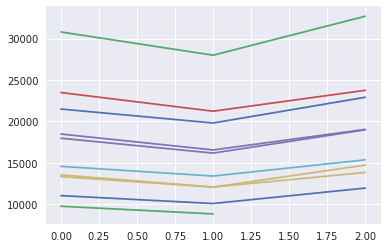

In [26]:
time_idx, top10 = findBusyAirport(data, 'Origin', topn=10)
for key in top10.keys():
    plt.plot(top10[key])

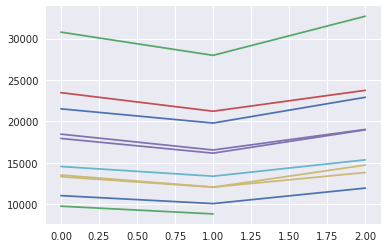

In [27]:
time_idx, top10 = findBusyAirport(data, 'Dest', topn=10)
for key in top10.keys():
    plt.plot(top10[key])

In [28]:
time_idx, top150_depart = findTimeAirport(data, airptkey='Origin', timeperiod='Year', topn=150)
time_idx, top150_arr = findTimeAirport(data, airptkey='Dest', timeperiod='Year', topn=150)

In [159]:
new_key_list = set(top150_depart.keys())|(set(top150_arr.keys()))
top150_busy = {}
while len(new_key_list) > 0:
    key_tmp = new_key_list.pop()
    key_val_depart = top150_depart[key_tmp] if key_tmp in top150_depart else np.nan
    key_val_arr = top150_arr[key_tmp] if key_tmp in top150_arr else np.nan
    top150_busy[key_tmp] = np.nansum([key_val_depart, key_val_arr])
    
# Sort airpot busy level
# top150_busy = sorted(top150_busy.items(), key=operator.itemgetter(1), reverse=True)
top150_busy =  sorted(top150_busy.items(), key=lambda x: x[1], reverse=True)

In [160]:
top150_busy_df = pd.DataFrame(top150_busy)
top150_busy_df.columns =['IATA', 'FlightCounts']

In [161]:
airport_info = pd.read_csv('/data/flights/airports.csv')

In [162]:
airport_info.columns

Index(['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude',
       'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source'],
      dtype='object')

In [163]:
latitude = []
longitude = []

for i in range(len(top150_busy_df)):
    latitude.append(airport_info[airport_info['IATA'] == top150_busy_df.iloc[i]['IATA']]['Latitude'].values[0])
    longitude.append(airport_info[airport_info['IATA'] == top150_busy_df.iloc[i]['IATA']]['Longitude'].values[0])

top150_busy_df['lat'] = latitude
top150_busy_df['lon'] = longitude

In [31]:
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='ShuangLiData', api_key='x9P8Cu5eM4AcKJtGKGN8')

In [166]:
df = top150_busy_df
df['text'] = df['IATA'] + '<br>FlightCounts' + (df['FlightCounts']).astype(str)

scl = [[0,"rgb(50, 20, 20)"],[0.35,"rgb(164, 0, 0)"],[0.5,"rgb(206, 22, 22)"],\
    [0.6,"rgb(255, 0, 0)"],[0.7,"rgb(255, 92, 92)"],[1,"rgb(255, 250, 250)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df['lon'],
        lat = df['lat'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = "circle",
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = df['FlightCounts'],
            cmax = df['FlightCounts'].max(),
            colorbar=dict(
                title="FlightCounts2016"
            )
        ))]

layout = dict(
        title = 'Top 150 busiest airports in 2016',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-airports' )

### Top 10 airports with the highest departure delays

In [198]:
np.array(data.columns)

array(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'AirlineID',
       'FlightNum', 'OriginAirportID', 'OriginAirportSeqID',
       'OriginCityMarketID', 'OriginStateFips', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID',
       'DestStateFips', 'DestWac', 'CRSDepTime', 'CRSArrTime',
       'DistanceGroup', 'DivAirportLandings', 'FlightDate',
       'UniqueCarrier', 'Carrier', 'TailNum', 'Origin', 'OriginCityName',
       'OriginState', 'OriginStateName', 'Dest', 'DestCityName',
       'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk',
       'CancellationCode', 'Div1Airport', 'Div1TailNum', 'Div2Airport',
       'Div2TailNum', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'TaxiIn', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups', 'Cancelled', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Flights', 'Dis

In [200]:
data[data['DepDelay']>0]['Origin']

0         JFK
3         JFK
4         JFK
5         JFK
6         JFK
7         JFK
9         JFK
10        JFK
22        JFK
27        JFK
28        JFK
29        JFK
31        LAX
32        LAX
35        LAX
36        LAX
42        LAX
46        LAX
49        LAX
50        LAX
57        LAX
61        LAX
64        JFK
65        JFK
66        JFK
67        JFK
68        JFK
69        JFK
78        JFK
82        JFK
         ... 
503644    GSO
503653    GSO
503658    GSO
503659    GSO
503661    GSO
503662    GSO
503663    GSO
503665    MIA
503666    MIA
503668    MIA
503669    MIA
503675    MIA
503678    MIA
503690    MIA
503692    MIA
503693    MIA
503694    MIA
503695    CVG
503696    CVG
503697    CVG
503703    CVG
503707    CVG
503709    CVG
503713    CVG
503716    CVG
503726    RDU
503728    RDU
503747    RDU
503753    COU
503757    COU
Name: Origin, dtype: object

In [202]:
time, top_delay_freq = findTimeAirport(data[data['DepDelay']>0], airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='DepDelayMinutes', agg_way='count')
time, top_delay_min = findTimeAirport(data[data['DepDelay']>0], airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='DepDelayMinutes', agg_way='sum')

In [205]:
top_delay_min

{'ATL': [583258.0, 322598.0, 375633.0],
 'DEN': [401653.0, 298544.0, 278430.0],
 'DFW': [276937.0, 274674.0, 270050.0],
 'EWR': [215708.0, 159163.0, nan],
 'IAH': [239702.0, 225014.0, 199783.0],
 'JFK': [208366.0, 146839.0, nan],
 'LAS': [197653.0, 165226.0, 143802.0],
 'LAX': [243707.0, 245647.0, 199958.0],
 'MCO': [198854.0, nan, 157602.0],
 'ORD': [549156.0, 406288.0, 327041.0],
 'PHX': [nan, nan, 155418.0],
 'SFO': [nan, 242487.0, 180273.0]}

In [203]:
top_delay_freq

{'ATL': [14891, 12141, 14796],
 'DEN': [10972, 9848, 9940],
 'DFW': [10212, 9034, 9460],
 'IAH': [6967, 6938, 7104],
 'LAS': [5930, 5227, 5781],
 'LAX': [7611, 7461, 7612],
 'MCO': [5021, 4191, 4977],
 'ORD': [11968, 10899, 10945],
 'PHX': [5766, 5239, 6550],
 'SFO': [5217, 5696, 5639]}

In [191]:
# Create column with key information
df_agg = data.groupby(['YY-M','Origin']).agg({'DepDelayMinutes':'sum'})
g = df_agg['DepDelayMinutes'].groupby(level=0, group_keys=False)
topn_df = g.nlargest(10)

In [8]:
np.array(data_fl.columns)

array(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'AirlineID',
       'FlightNum', 'OriginAirportID', 'OriginAirportSeqID',
       'OriginCityMarketID', 'OriginStateFips', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID',
       'DestStateFips', 'DestWac', 'CRSDepTime', 'CRSArrTime',
       'DistanceGroup', 'DivAirportLandings', 'FlightDate',
       'UniqueCarrier', 'Carrier', 'TailNum', 'Origin', 'OriginCityName',
       'OriginState', 'OriginStateName', 'Dest', 'DestCityName',
       'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk',
       'CancellationCode', 'Div1Airport', 'Div1TailNum', 'Div2Airport',
       'Div2TailNum', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
       'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn',
       'TaxiIn', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups', 'Cancelled', 'Diverted', 'CRSElapsedTime',
       'ActualElapsedTime', 'AirTime', 'Flights', 'Dis

In [5]:
# key features:

ArrDel15, Month, DayOfWeek, DepartAirportbusylevel, ArrivalAirportbusylevel, distance, carrier, DepTimeBlk

,Year,Quarter,Month,DayofMonth,DayOfWeek,AirlineID,FlightNum,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2014,1,1,1,3,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,1,2,4,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,1,3,5,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,4,6,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,1,5,7,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2014,1,1,6,1,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2014,1,1,7,2,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2014,1,1,8,3,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2014,1,1,9,4,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2014,1,1,10,5,19805,1,12478,1247802,31703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ax = sns.stripplot(y="Carrier", x="DepDelayMinutes", size = 4, data=data_2016, linewidth = 0.5,  jitter=True, alpha=0.2)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x, 60)]) for x in ax.get_xticks()])

plt.xlabel('Departure delay', fontsize=12)

ax.yaxis.label.set_visible(False)

plt.tight_layout(w_pad=3) 

In [ ]:
ax = sns.stripplot(y="Carrier", x="DepDelayMinutes", size = 4, palette = colors,
                    data=data_fl, linewidth = 0.5,  jitter=True, alpha=0.3)
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5}, color='w', labelpad=20)
ax.yaxis.label.set_visible(False)
plt.tight_layout(w_pad=3) 

If the null is true, and you have exponential distributions, you're testing equality of the scale parameters. Location-testing the means of the logs will test equality of logs of the scale parameters against a location shift alternative in the logs (change of scale in the original values). If you conclude that logλ1≠logλ2 logλ1≠logλ2 in a location test in the logs, that's logically the same as concluding that λ1≠λ2 λ1≠λ2. So testing the logs with a t-test works perfectly well as a test of the original hypothesis.
[If you do that test in the logs, I'd be inclined to suggest doing an equal-variance test in that case.] So - with the mere intervention of perhaps a sentence or two justifying the connection, similar to what I have above - you should be able write your conclusions not about the log of the participation metric, but about the participation metric itself.